<a href="https://colab.research.google.com/github/rumeysacelik/RealOrFakeClassifier/blob/main/FakeorReal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.data import Dataset
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random


In [ ]:
from google.colab import drive
drive.mount('/content/gdirve')

Drive already mounted at /content/gdirve; to attempt to forcibly remount, call drive.mount("/content/gdirve", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/imageprocessing/archive 2/data.csv').sample(frac=1)
print(df.columns)
print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/imageprocessing/archive 2/data.csv'

In [ ]:
df = pd.read_csv('/content/gdirve/MyDrive/imageprocessing/archive 2/data.csv').sample(frac=1)

# Doğru sütun adını kullanarak dosya yollarını düzenleyelim
df['images_id'] = df['images_id'].apply(lambda x: '/content/drive/MyDrive/imageprocessing/archive 2/real/'+x+'.jpg' if 'real' in x else '/content/drive/MyDrive/imageprocessing/archive 2/fake/'+x+'.jpg')
df['label'] = df['label'].map(lambda x: 1 if x=='fake' else 0)
df.rename(columns={'images_id':'path'}, inplace=True)
print(df.head())


                                                   path  label
1121  /content/drive/MyDrive/imageprocessing/archive...      1
1186  /content/drive/MyDrive/imageprocessing/archive...      1
462   /content/drive/MyDrive/imageprocessing/archive...      0
81    /content/drive/MyDrive/imageprocessing/archive...      0
63    /content/drive/MyDrive/imageprocessing/archive...      0


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/imageprocessing/archive 2/data.csv').sample(frac=1)

# df['images_id'] = df['images_id'].apply(lambda x: '/content/gdirve/MyDrive/imageprocessing/archive 2/real/'+x+'.jpg'\
#                                                       if x[:4]=='real' else '/content/gdirve/MyDrive/imageprocessing/archive 2/fake/'+x+'.jpg')
# df['label'] = df['label'].map(lambda x: 1 if x=='fake' else 0)
# df.rename(columns={'images_id':'path'}, inplace=True)
# df

In [ ]:
# Sabitleri ayarlayın
batch_size = 32
image_size = 224
shuffle_buffer_size = 1000
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

input_tensor = Input(shape=(224, 224, 3))

# MobileNetV3Small Modelini yükle
pretrained_model1 = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=input_tensor)
pretrained_model1.trainable = False

# MobileNetV3Large Modelini yükle
pretrained_model2 = MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=input_tensor)
pretrained_model2.trainable = False

# Katman isimlerini benzersiz hale getirme
for layer in pretrained_model1.layers:
    layer._name = "small_" + layer.name

for layer in pretrained_model2.layers:
    layer._name = "large_" + layer.name

# Her modelin çıktılarını benzersiz adlarla tanımla
output_small = GlobalAveragePooling2D(name='avg_pool_small')(pretrained_model1.output)
output_large = GlobalAveragePooling2D(name='avg_pool_large')(pretrained_model2.output)

# Model çıktılarını birleştirme
concatenated = Concatenate(name='concat_features')([output_small, output_large])
x = Dense(256, activation='relu', name='dense_relu')(concatenated)
x = Dropout(0.5, name='dropout')(x)
final_output = Dense(1, activation='sigmoid', name='final_output')(x)

# Yeni modeli oluşturma
model = Model(inputs=input_tensor, outputs=final_output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Model özeti
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 large_small_input_2 (Input  [(None, 224, 224, 3)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 large_rescaling_3 (Rescali  (None, 224, 224, 3)          0         ['large_small_input_2[0][0]'] 
 ng)                                                                                              
                                                                                                  
 large_Conv (Conv2D)         (None, 112, 112, 16)         432       ['large_rescaling_3[0][0]']   
                                                                                            

In [ ]:
from sklearn.model_selection import train_test_split

# Veri kümesini eğitim, doğrulama ve test alt kümelerine bölelim
X = df['path'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)  # 0.25 x 0.8 = 0.2


In [ ]:
# Dosya yollarını kontrol et
sample_paths = df['path'].values[:5]  # İlk 5 dosya yolunu kontrol et
for path in sample_paths:
    print(f"Checking file: {path}")
    if os.path.exists(path):
        print(f"File exists: {path}")
    else:
        print(f"File does not exist: {path}")


Checking file: /content/drive/MyDrive/imageprocessing/archive 2/fake/fake_579.jpg
File does not exist: /content/drive/MyDrive/imageprocessing/archive 2/fake/fake_579.jpg
Checking file: /content/drive/MyDrive/imageprocessing/archive 2/fake/fake_637.jpg
File does not exist: /content/drive/MyDrive/imageprocessing/archive 2/fake/fake_637.jpg
Checking file: /content/drive/MyDrive/imageprocessing/archive 2/real/real_515.jpg
File does not exist: /content/drive/MyDrive/imageprocessing/archive 2/real/real_515.jpg
Checking file: /content/drive/MyDrive/imageprocessing/archive 2/real/real_172.jpg
File does not exist: /content/drive/MyDrive/imageprocessing/archive 2/real/real_172.jpg
Checking file: /content/drive/MyDrive/imageprocessing/archive 2/real/real_156.jpg
File does not exist: /content/drive/MyDrive/imageprocessing/archive 2/real/real_156.jpg


All files are present.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    image = image / 255.0
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

def create_dataset(paths, labels, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    if is_training:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset


In [ ]:
# TensorFlow veri kümelerini oluşturalım
train_ds = create_dataset(X_train, y_train, batch_size, is_training=True)
val_ds = create_dataset(X_val, y_val, batch_size, is_training=False)
test_ds = create_dataset(X_test, y_test, batch_size, is_training=False)


In [ ]:
import os

# Dosya yollarını kontrol etme fonksiyonu
def check_files_exist(paths):
    missing_files = []
    for path in paths:
        if not os.path.exists(path):
            missing_files.append(path)
    return missing_files

# Eksik dosyaları kontrol et
missing_files = check_files_exist(df['path'].values)
if missing_files:
    print(f"Missing files: {missing_files}")
else:
    print("All files are present.")


In [ ]:
# Eksik dosyaları çıkarma
df = df[~df['path'].isin(missing_files)]
X = df['path'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Callbacks tanımlama
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, cooldown=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model eğitimi
history = model.fit(train_ds, epochs=60, validation_data=val_ds, callbacks=[early_stopping, reduce_lr])


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

DataFrame boyutu: (0, 2)
Missing files in df: 0
Filtrelemeden önce df
Empty DataFrame
Columns: [path, label]
Index: []
Filtrelemeden sonra df
Empty DataFrame
Columns: [path, label]
Index: []
Filtrelemeden sonra DataFrame boyutu: (0, 2)
Veri seti boş, missing_files listesindeki dosyalar nedeniyle!


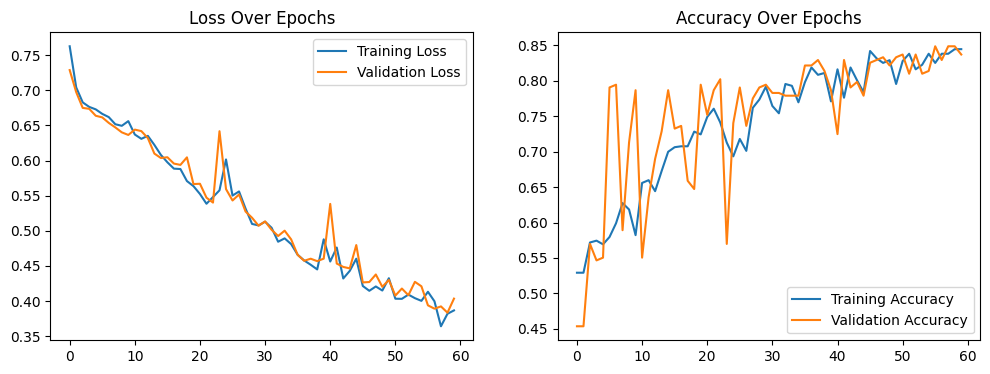

In [ ]:
import matplotlib.pyplot as plt

# Kayıp grafikleri
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Doğruluk grafikleri
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()


In [ ]:
# Model performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


9/9 [==============================] - 18s 2s/step - loss: 0.4484 - accuracy: 0.8178
Test Loss: 0.4483688175678253
Test Accuracy: 0.817829430103302


9/9 [==============================] - 28s 2s/step


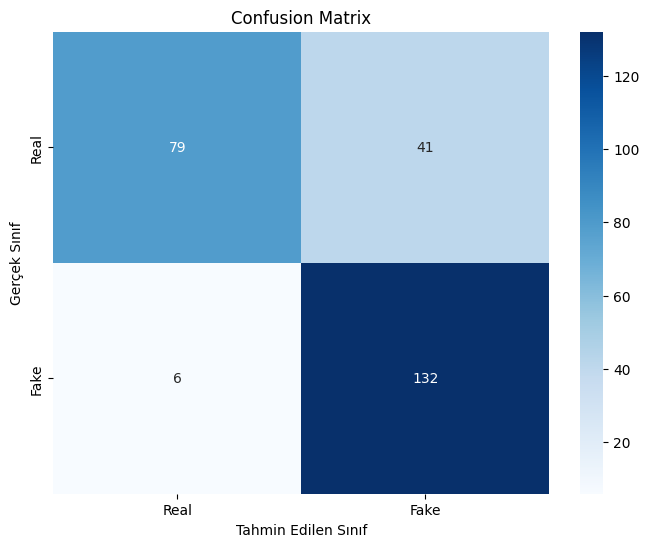

              precision    recall  f1-score   support

        Real       0.93      0.66      0.77       120
        Fake       0.76      0.96      0.85       138

    accuracy                           0.82       258
   macro avg       0.85      0.81      0.81       258
weighted avg       0.84      0.82      0.81       258



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test veri kümesi üzerinde tahmin yapın
y_pred = model.predict(test_ds)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Gerçek sınıfları alın
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Karışıklık matrisini hesaplayın
cm = confusion_matrix(y_true, y_pred_classes)

# Karışıklık matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

# Sınıflandırma raporunu hesaplayın
print(classification_report(y_true, y_pred_classes, target_names=['Real', 'Fake']))


In [ ]:
# Modeli kaydetme
model.save('ensemble_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
